## Building a First Model
- In the last notebook / lesson we loaded in the data from retrosheet and did some processing to get the team level statistics.
- We saved that data to a file called 'df_bp1.csv'
- In this notebook, we will load in that data, do some initital data exploration, and then build and evaluate our first predictive model 

In [16]:
# Uncomment if you need to install any of the following packages
# !pip install lightgbm
# !pip install ml_insights --upgrade
# !pip install structureboost

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [18]:
df=pd.read_csv('df_bp1.csv')

/var/folders/4n/m6y9jtrx6m1_59wkdvlnxsm80000gn/T/ipykernel_3797/3742704531.py:1: DtypeWarning: Columns (13,14,15,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('df_bp1.csv')


## Data Checks / Exploration

In [19]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96276 entries, 0 to 96275
Data columns (total 194 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    date                  96276 non-null  int64  
 1    dblheader_code        96276 non-null  int64  
 2    day_of_week           96276 non-null  object 
 3    team_v                96276 non-null  object 
 4    league_v              96276 non-null  object 
 5    game_no_v             96276 non-null  int64  
 6    team_h                96276 non-null  object 
 7    league_h              96276 non-null  object 
 8    game_no_h             96276 non-null  int64  
 9    runs_v                96276 non-null  int64  
 10   runs_h                96276 non-null  int64  
 11   outs_total            96276 non-null  int64  
 12   day_night             96276 non-null  object 
 13   completion_info       83 non-null     object 
 14   forfeit_info          1 non-null      object 
 15   

In [20]:
df.season.value_counts().sort_index()

season
1980    2105
1981    1394
1982    2107
1983    2109
1984    2105
1985    2103
1986    2103
1987    2105
1988    2100
1989    2106
1990    2105
1991    2104
1992    2106
1993    2269
1994    1600
1995    2017
1996    2267
1997    2266
1998    2432
1999    2428
2000    2429
2001    2429
2002    2426
2003    2430
2004    2428
2005    2431
2006    2429
2007    2431
2008    2428
2009    2430
2010    2430
2011    2429
2012    2430
2013    2431
2014    2430
2015    2429
2016    2428
2017    2430
2018    2431
2019    2429
2020     898
2021    2429
2022    2430
Name: count, dtype: int64

In [21]:
hv_mean = df.home_victory.mean()
hv_mean

0.538368856205077

In [22]:
df.run_diff.value_counts()

run_diff
 1     16912
-1     10907
 2      9029
-2      8675
 3      7169
-3      6864
 4      5586
-4      5385
 5      4012
-5      3950
 6      2938
-6      2794
 7      2036
-7      2000
 8      1481
-8      1337
 9       989
-9       904
 10      630
-10      612
 11      403
-11      369
 12      257
-12      226
-13      169
 13      162
 14       96
-14       89
 15       49
-15       44
-16       38
 0        35
 16       35
 17       19
-17       17
-18       12
 19       10
 18        9
-19        7
 21        6
-21        4
-20        3
 20        3
 22        1
-22        1
-27        1
-23        1
Name: count, dtype: int64

In [23]:
df.outs_total.value_counts()

outs_total
51     43646
54     40092
60      1890
53      1844
52      1634
66      1016
58       882
59       809
72       545
64       442
57       426
65       416
78       303
70       251
63       217
71       214
84       161
77       132
42       125
76       121
39       120
69       113
82        76
83        73
90        73
75        70
96        46
89        46
36        32
30        31
81        28
48        27
45        23
33        23
88        23
102       23
94        20
95        19
31        17
41        17
108       17
40        12
100       11
87        11
46        10
101       10
93        10
43         9
28         8
106        8
38         8
114        8
37         7
27         7
34         7
44         7
32         6
105        6
47         6
120        5
111        4
113        4
49         4
29         4
107        3
118        3
132        2
35         2
50         2
112        2
131        1
148        1
129        1
79         1
126        1
55         1
9

In [24]:
df.home_victory[df.outs_total==53].mean()

0.9994577006507592

In [25]:
df.loc[(df.outs_total==53) & (df.home_victory!=1),:]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v
56258,20050915,0,Thu,SLN,NL,148,CHN,NL,147,6,1,53,N,NaN,NaN,NaN,CHI11,37849.0,167,300000030,000000001,33,9,1,0,0,5,0,1,0,5,0,6,0,1,1,0,6,2,1,1,1,0,26,12,1,0,1,0,33,8,0,0,1,1,0,0,0,2,0,8,0,0,1,0,8,3,5,5,0,0,27,13,1,0,2,0,wolfj901,Jim Wolf,holbs901,Sam Holbrook,vanol901,Larry Vanover,marsr901,Randy Marsh,NaN,(none),NaN,(none),larut101,Tony LaRussa,baked002,Dusty Baker,suppj001,Jeff Suppan,priom001,Mark Prior,NaN,(none),walkl001,Larry Walker,suppj001,Jeff Suppan,priom001,Mark Prior,ecksd001,David Eckstein,6,edmoj001,Jim Edmonds,8,pujoa001,Albert Pujols,3,walkl001,Larry Walker,9,rodrj002,John Rodriguez,7,nunea001,Abraham Nunez,5,moliy001,Yadier Molina,2,lunah001,Hector Luna,4,suppj001,Jeff Suppan,1,hairj002,Jerry Hairston,8,walkt002,Todd Walker,4,lee-d002,Derrek Lee,3,garcn001,Nomar Garciaparra,5,burnj001,Jeromy Burnitz,9,murtm001,Matt Murton,7,peren001,Neifi Perez,6,blanh001,Henry Blanco,2,priom001,Mark Prior,1,NaN,Y,2005,-5,0,7,200509150,0.268813,0.270416,0.323345,0.334703,0.439957,0.424193,0.763303,0.758897,63.0,88.0,36.0,37.0,98.0,99.0,0.271073,0.263467,0.322351,0.32737,0.444444,0.39569,0.766795,0.723061,12.0,20.0,6.0,5.0,15.0,23.0


In [26]:
df.game_no_h.value_counts().sort_index()

game_no_h
1      612
2      611
3      612
4      611
5      609
6      614
7      615
8      627
9      631
10     623
11     608
12     600
13     609
14     608
15     620
16     621
17     622
18     626
19     632
20     612
21     601
22     616
23     609
24     597
25     587
26     599
27     611
28     617
29     622
30     625
31     642
32     645
33     622
34     620
35     607
36     600
37     594
38     586
39     591
40     602
41     623
42     631
43     628
44     618
45     625
46     627
47     611
48     602
49     607
50     608
51     598
52     609
53     604
54     616
55     624
56     604
57     607
58     614
59     635
60     635
61     600
62     594
63     592
64     594
65     599
66     619
67     603
68     592
69     603
70     588
71     586
72     588
73     595
74     598
75     602
76     627
77     621
78     603
79     613
80     595
81     593
82     588
83     583
84     599
85     592
86     602
87     588
88     582
89     596
90     579


### Moral of the Story: Interrogate your data!
- Ask questions
- Make hypotheses
- Dig into details to confirm or disprove them

## Begin Modeling

In [27]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018)]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [28]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [29]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [30]:
X_train.shape, X_valid.shape, X_test.shape, 

((85954, 4), (3327, 4), (4859, 4))

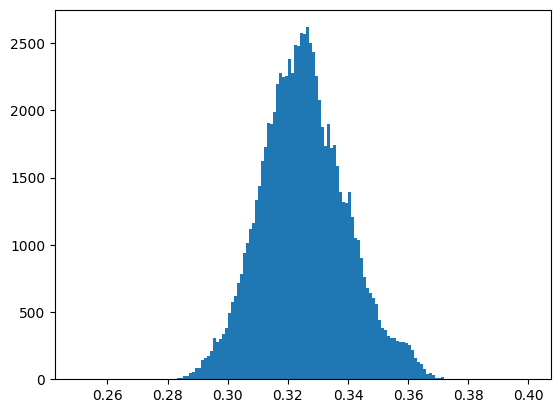

In [31]:
plt.hist(X_train.OBP_162_h, np.linspace(.25,.4,151));

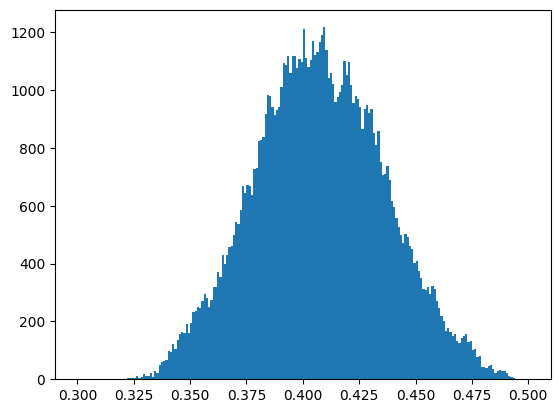

In [32]:
plt.hist(X_train.SLG_162_v, np.linspace(.3,.5,201));

In [33]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 46303, number of negative: 39651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 85954, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538695 -> initscore=0.155091
[LightGBM] [Info] Start training from score 0.155091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [34]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [35]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6830424295126333, 0.6905459938835579)

In [36]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

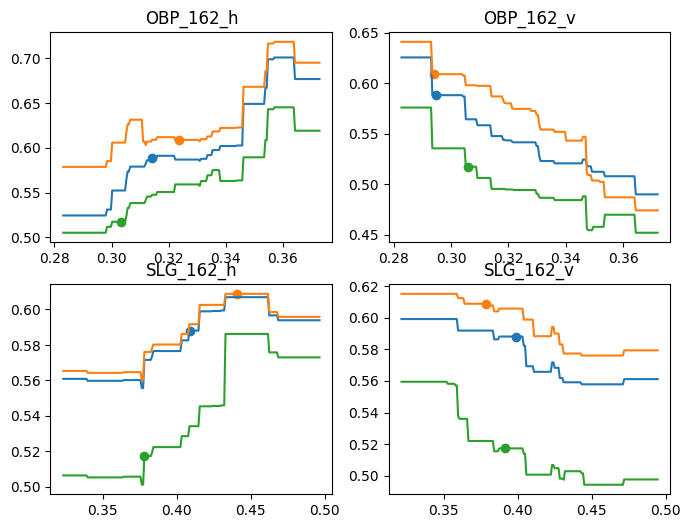

In [37]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=2)

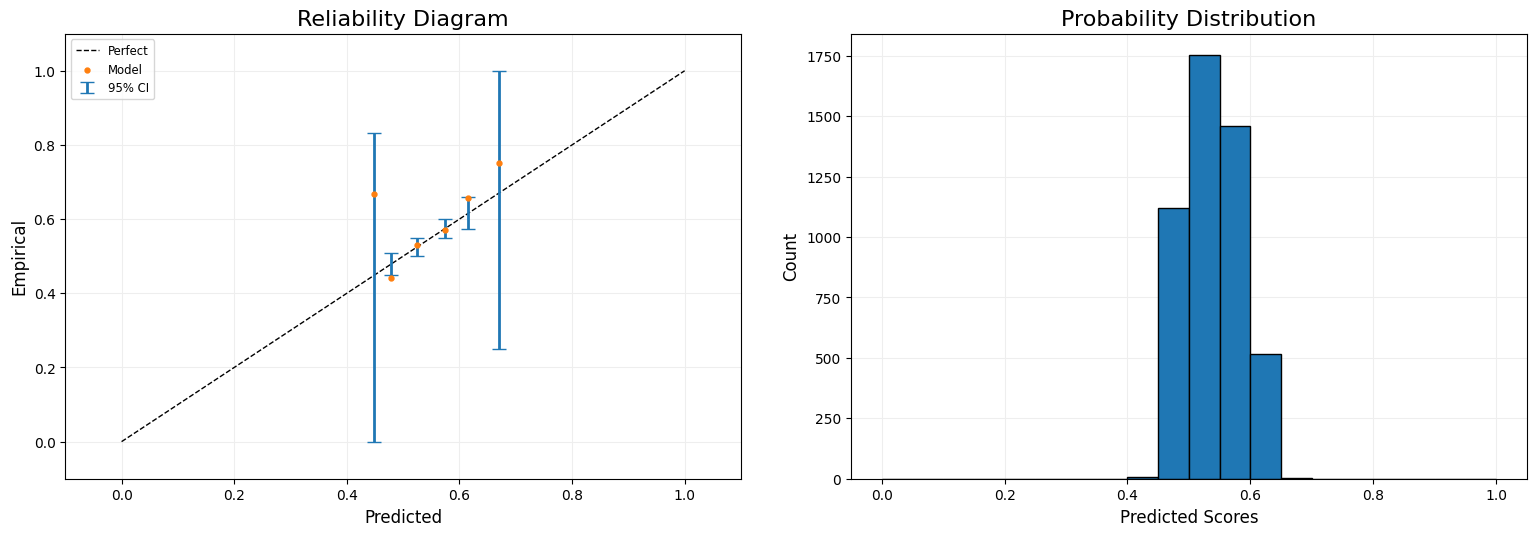

In [38]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [39]:
fc = stb.get_basic_config(X_train, stb.default_config_dict())

stb1 = stb.StructureBoost(max_depth=3, learning_rate=.02, feature_configs = fc, num_trees=2000)
stb1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5)

i=0, eval_set_loss = 0.6904403794776431
i=10, eval_set_loss = 0.6895669029473954
i=20, eval_set_loss = 0.6884204225383985
i=30, eval_set_loss = 0.687274237167239
i=40, eval_set_loss = 0.6861453464150361
i=50, eval_set_loss = 0.6855539921025002
i=60, eval_set_loss = 0.6844892780441205
i=70, eval_set_loss = 0.6839991575673929
i=80, eval_set_loss = 0.6832006805145512
i=90, eval_set_loss = 0.6826466180396877
i=100, eval_set_loss = 0.6823448930836821
i=110, eval_set_loss = 0.6821898028586767
i=120, eval_set_loss = 0.6819255827558456
i=130, eval_set_loss = 0.6818155240887619
i=140, eval_set_loss = 0.6816216294229265
i=150, eval_set_loss = 0.6814346910506417
i=160, eval_set_loss = 0.6812702239857672
i=170, eval_set_loss = 0.6809363700892458
i=180, eval_set_loss = 0.6807517678598056
i=190, eval_set_loss = 0.6805166393345418
i=200, eval_set_loss = 0.6804358408350633
i=210, eval_set_loss = 0.6802936974381846
i=220, eval_set_loss = 0.6801800568407381
i=230, eval_set_loss = 0.680133714534928
i=240

In [40]:
preds_stb = stb1.predict(X_test)

In [41]:
log_loss(y_test, preds_stb), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6832433096928108, 0.6905459938835579)

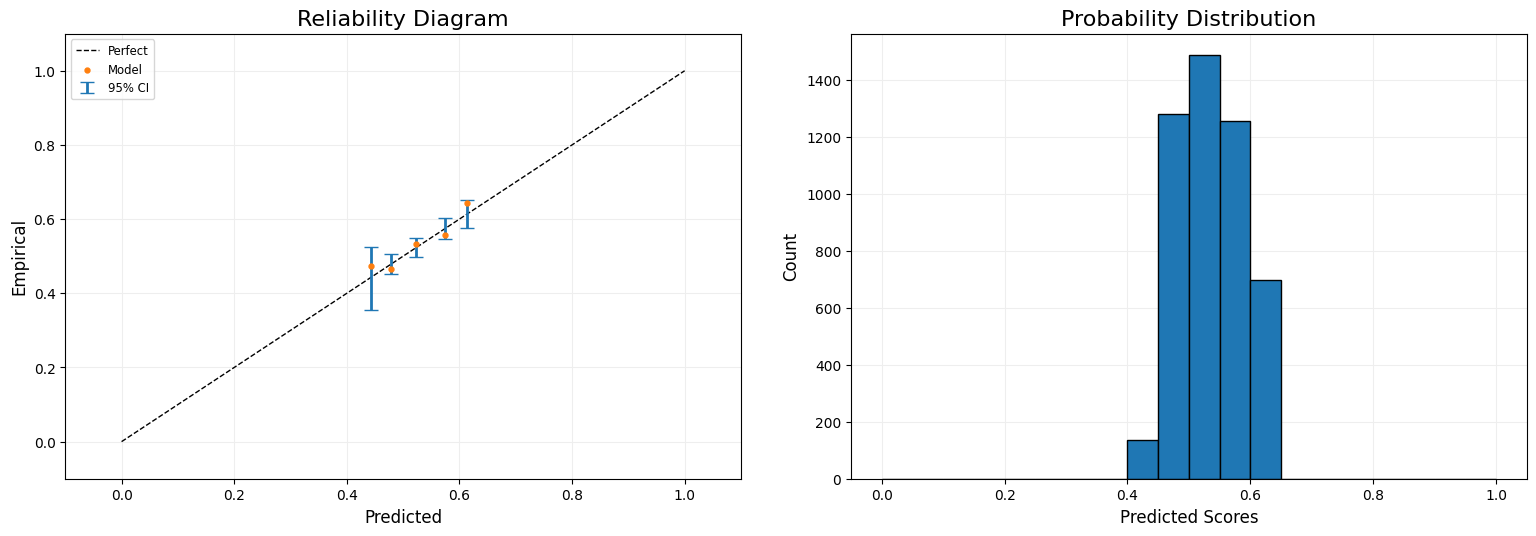

In [42]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_stb, show_histogram=True);

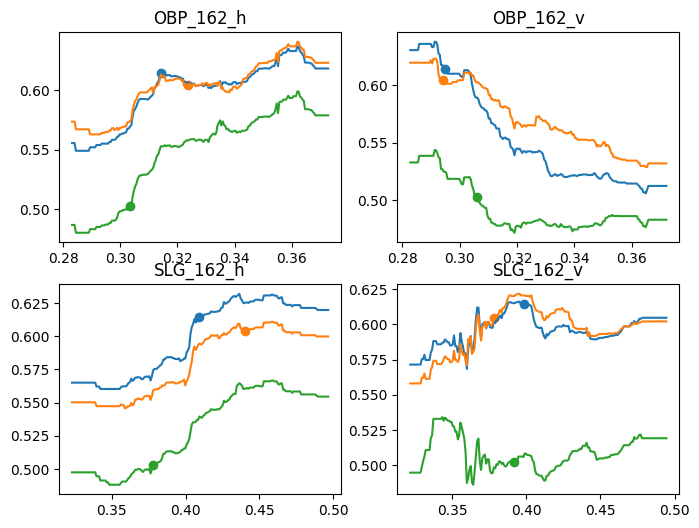

In [43]:
rd= mli.get_range_dict(X_train)
mli.ice_plot(stb1, plot_pts, X_test.columns, rd, plots_per_row=2)